# Use Google API to find various stores in Davidson County

In [1]:
import requests
import json
import time
import pickle
import folium
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import Polygon
# import censusdata
import pandas as pd
import math
from sklearn.metrics.pairwise import haversine_distances
from sklearn.cluster import AgglomerativeClustering
from bs4 import BeautifulSoup as BS
import ast
from itertools import combinations
from collections import Counter
#from scipy.cluster.hierarchy 

%matplotlib inline

## The Google `nearbysearch` api endpoint returns locations of various `types` within a `radius` centered on a lat/lng coordinate `location`
## We can use this to find locations that may be relevant to identifying food deserts

Google API key is stored in a separate file for security

In [2]:
hidden = pd.read_pickle('../data/API_key.pkl')
api_key = hidden.loc[0][1]

Set default values to use for testing and later use

In [3]:
location = '36.1612, -86.7775' # lat, lng as a string
radius = '32200' # in meters, 20 miles, approximate distance from Davidson center to furthest edge
types = 'grocery_or_supermarket' # select single store type as a test case

In [4]:
all_types = ['bakery',
             'convenience_store',
             'department_store',
             'drugstore',
             'gas_station',
             'grocery_or_supermarket',
             'home_goods_store',
             'supermarket',
             'pharmacy']
# additional types are 'store' and 'shopping_mall'

This is the function that will do the heavy lifting of preparing and making the request

In [5]:
# Modified from https://python.gotrained.com/google-places-api-extracting-location-data-reviews/

def search_places_by_coordinate(location, radius, types, api_key, sleep_sec = 2):
    endpoint_url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    places = []
    params = {
        'location': location,
        'radius': radius,
        'types': types,
        'key': api_key
    }
    res = requests.get(endpoint_url, params = params)
    results =  json.loads(res.content)
    places.extend(results['results'])
    time.sleep(sleep_sec)
    while "next_page_token" in results:
        params['pagetoken'] = results['next_page_token'],
        res = requests.get(endpoint_url, params = params)
        results = json.loads(res.content)
        places.extend(results['results'])
        time.sleep(sleep_sec)
    return places

Test the api request using just `grocery_or_supermarket` and encompassing whole county

In [6]:
grocery_stores_20_mi_radius = search_places_by_coordinate(location, radius, types, api_key)

Check the response

In [7]:
len(grocery_stores_20_mi_radius)

3

In [8]:
grocery_stores_20_mi_radius[0]['geometry']['location']

{'lat': 36.16341249999999, 'lng': -86.779421}

In [9]:
nash_map = folium.Map([36.1612, -86.7775])
for store in grocery_stores_20_mi_radius:
    coords = store['geometry']['location']
    lat = coords['lat']
    lng = coords['lng']
    folium.Marker([lat, lng]).add_to(nash_map)
nash_map

Expand to multiple store types

In [10]:
multiple_stores_20_mi_radius = search_places_by_coordinate(location, radius, all_types, api_key)

In [11]:
# Still only 60 stores, turns out it is a return limit of the endpoint
len(multiple_stores_20_mi_radius)

21

## Since endpoint only return up to 60 locations per request, will make multiple requests across the county

#### Start out by making a grid over the county

In [12]:
# File retrieved from data.nashville.gov
davidson_county = gpd.read_file('../data/Davidson County Border (GIS).geojson')
davidson_county.crs = "EPSG:4326"

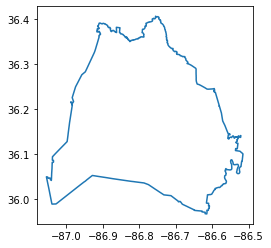

In [13]:
davidson_county.boundary.plot();

Find total geographic bounds of davidson county

In [14]:
xmin,ymin,xmax,ymax =  davidson_county.total_bounds

Divide total bounds into 10x10 grid

In [15]:
x_increment = (xmax-xmin)/10
y_increment = (ymax-ymin)/10

In [16]:
# determine boundary locations along x-axis
grid_x_boundaries = [xmin]
new_bound = xmin
for i in range(10):
    new_bound = new_bound + x_increment
    grid_x_boundaries.append(new_bound)

In [17]:
# determine boundary locations along y-axis
grid_y_boundaries = [ymin]
new_bound = ymin
for i in range(10):
    new_bound = new_bound + y_increment
    grid_y_boundaries.append(new_bound)

In [18]:
# get lats and lons in separate lists for center of each grid square
lons = []
lats = []
for left, right in zip(grid_x_boundaries[:-1], grid_x_boundaries[1:]):
    for top, bottom in zip(grid_y_boundaries[:-1], grid_y_boundaries[1:]):
        lats.append((top+bottom)/2)
        lons.append((left+right)/2)
    

In [19]:
# convery to gpd points
grid_centers = gpd.points_from_xy(lons, lats)

In [20]:
# put into geodataframe
grid_gdf = gpd.GeoDataFrame(geometry = grid_centers, crs = "EPSG:4326")

<AxesSubplot:>

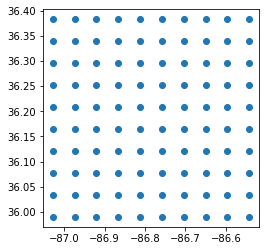

In [21]:
grid_gdf.plot()

We'll get more into this in a bit, but we need to add a buffer around the county to include stores slightly outside (1 mile). These stores could influence the existance of food deserts

Geopandas buffers are calculated based on the crs of the gdf. Since we are usine "EPSG:4326" we know the units are degrees. Using this conversion from the USGS (https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps?qt-news_science_products=0#qt-news_science_products): "One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet." We can approximate the number of degrees in a mile as: 1/69 = 0.014492753623188406

C:\Users\16159\AppData\Local\Temp/ipykernel_30208/1592221078.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  davidson_county_buffer = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.014492753623188406),


<AxesSubplot:>

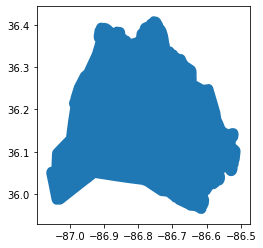

In [22]:
davidson_county_buffer = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")
davidson_county_buffer.plot()

In [24]:
# Only keep points within the buffered Davidson county polygon
keep_points = []
for ind, p in grid_gdf['geometry'].iteritems():
    if p.within(davidson_county.loc[0, 'geometry']) or p.within(davidson_county.loc[1, 'geometry']):
        keep_points.append(ind)

grid_points_sub = grid_gdf.loc[keep_points]

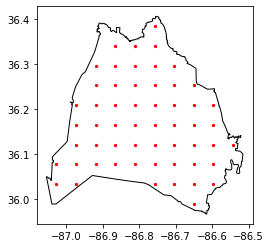

In [25]:
base = davidson_county.plot(color='white', edgecolor='black')

grid_points_sub.plot(ax=base, marker='o', color='red', markersize=5);

## Now with grid points laid out across county iterate over full list of types and points to get more store

Since looking at smaller areas, adjust radius. Since points are based on lat and lng now, need to calculate distance differently. Distance in meters from lat, lng coordinates is best calculated using the `haversine distance` formula

In [26]:
# function adapted from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
def dist_in_meters(point_1, point_2):
    point_1 = [math.radians(l) for l in [point_1.y, point_1.x]]
    point_2 = [math.radians(l) for l in [point_2.y, point_2.x]]
    dist_array_m = haversine_distances([point_1, point_2])*6371000
    return dist_array_m[0][1]

In [27]:
grid_point_radius = dist_in_meters(grid_points_sub.loc[1, 'geometry'], grid_points_sub.loc[2, 'geometry'])

Check to make sure the entire county is covered

C:\Users\16159\AppData\Local\Temp/ipykernel_30208/3228033640.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_points_sub_buffers = gpd.GeoDataFrame(geometry = grid_points_sub['geometry'].buffer(grid_point_radius_mile),


NameError: name 'davidson_tracts' is not defined

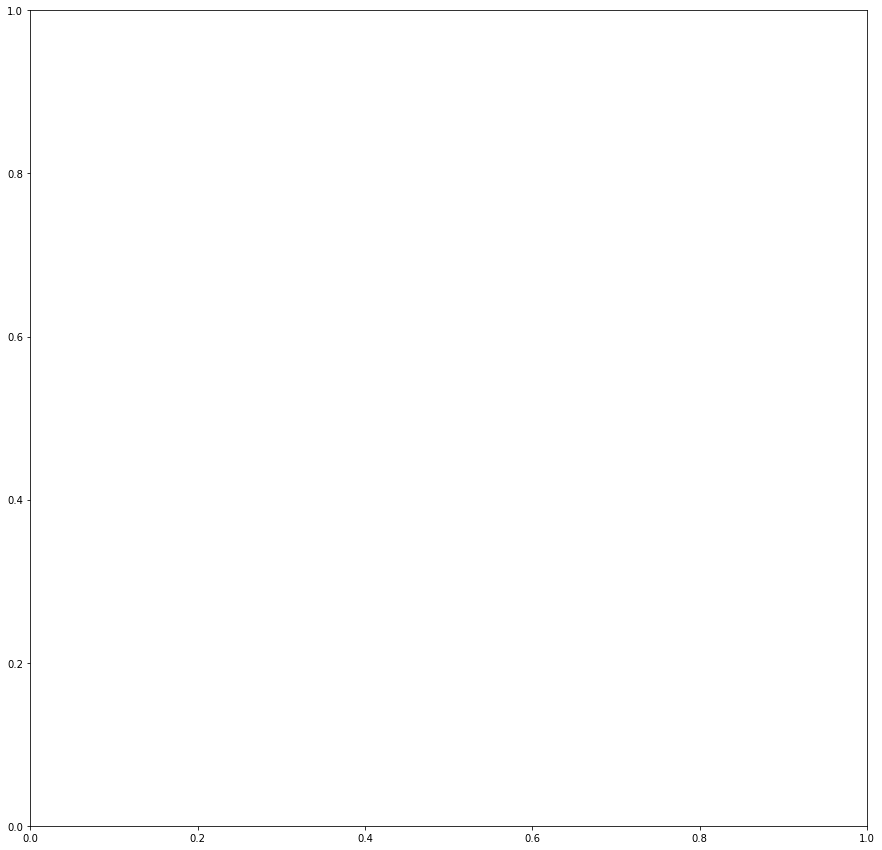

In [28]:
grid_point_radius_mile = 3.0258050367212114828/69
grid_points_sub_buffers = gpd.GeoDataFrame(geometry = grid_points_sub['geometry'].buffer(grid_point_radius_mile),
                                          crs = "EPSG:4326")
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.boundary.plot(ax=ax, edgecolor = 'blue', color='blue', alpha = 0.15)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = grid_points_sub_buffers.plot(ax=ax, color = 'green', alpha = 0.1)
grid_points_sub.plot(ax=ax, marker='o', color='red', markersize=5)
;

It covers all of the county

In [29]:
# creating output list in separate cell in case need to run for loop multiple times because of time out errors
responses = []

#### This one can take a while, run with caution

In [ ]:
for ind_2, t in enumerate(all_types):
    print(ind_2, t) # just to keep track of progress
    # if ind_2 >= 1: # uncomment and tab below over if need to start later in all_types list
    for ind, (lng, lat) in enumerate(list(zip(grid_points_sub['geometry'].x, grid_points_sub['geometry'].y))): # note that lat and lng are switched
        # print(ind, lat, lng) # again, to keep track of progress
        # if ind >= 0: # uncomment and tab below if need to start later in grid df
        location = '{}, {}'.format(lat, lng)
        responses.append(search_places_by_coordinate(location, grid_point_radius, t, api_key))

0 bakery


In [ ]:
# total number of requests
len(responses)

`responses` contains list of list of locations. Flatten to get single list of locations

In [ ]:
responses_flat = [i for l in responses for i in l]

In [ ]:
# total number of stores across all requests
len(responses_flat)

There is probably a better way to do this but use the following steps to find unique stores:
- find unique `place_id`
- iterate through unique ids and flattened responses for first instance of id

In [ ]:
unique_store_id = set([i['place_id'] for i in responses_flat])

In [ ]:
unique_grocery_store = []
for i in unique_store_id:
    for store in responses_flat:
        if store['place_id'] == i:
            unique_grocery_store.append(store)
            break

In [ ]:
# number of unique ids
len(unique_grocery_store)

Extract lat and lng from store locations and put in dataframe

In [ ]:
lats = []
lons = []
for store in unique_grocery_store:
    lats.append(store['geometry']['location']['lat'])
    lons.append(store['geometry']['location']['lng'])
all_store_locations = gpd.points_from_xy(lons, lats)
all_store_gdf = gpd.GeoDataFrame(geometry = all_store_locations, crs = "EPSG:4326")

keep only stores within buffered Davidson County polygon

In [ ]:
keep_stores = []
for ind, p in all_store_gdf['geometry'].iteritems():
    if p.within(davidson_county_buffer.loc[0, 'geometry']) or p.within(davidson_county_buffer.loc[1, 'geometry']):
        keep_stores.append(ind)

davidson_store_gdf = all_store_gdf.loc[keep_stores]

In [ ]:
# number of stores in Davidson County
len(davidson_store_gdf)

Plot locations on folium map

In [ ]:
nash_map = folium.Map([36.1612, -86.7775])
for ind, store in davidson_store_gdf.iterrows():
    lng = store['geometry'].x
    lat = store['geometry'].y
    folium.Marker([lat, lng]).add_to(nash_map)
nash_map

And again just using geopandas to see points in context of store locations within county

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_county.plot(color='white', edgecolor='black', ax = ax)
davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5);

# From the USDA website:  

#### The area of a food desert is definied by the census tract

https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation/
"Most measures and definitions take into account at least some of the following indicators of access:

- Accessibility to sources of healthy food, as measured by distance to a store or by the number of stores in an area.
- Individual-level resources that may affect accessibility, such as family income or vehicle availability.
- Neighborhood-level indicators of resources, such as the average income of the neighborhood and the availability of public transportation."  

"This program defines a low-income census tract as any tract where:

- The tract’s poverty rate is 20 percent or greater; or
- The tract’s median family income is less than or equal to 80 percent of the State-wide median family income; or
- The tract is in a metropolitan area and has a median family income less than or equal to 80 percent of the metropolitan area's median family income."  

"Three measures of food access based on distance to a supermarket are provided in the Atlas:

- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than ½ mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. Using this measure, an estimated 54.4 million people, or 17.7 percent of the U.S. population, live in tracts that are low-income and low access and are more than ½ mile or 10 miles from the nearest supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. This measure shows that an estimated 19 million people, or 6.2 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 10 miles from a supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 20 miles for a rural area. Under this measure, an estimated 17.3 million people, or 5.6 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 20 miles from a supermarket."

#### Read in census tract shape file and narrow down to Davidson County

In [ ]:
tennessee_tracts = gpd.read_file('data/cb_2018_47_tract_500k/cb_2018_47_tract_500k.shx')
tennessee_tracts.crs = "EPSG:4326"

In [ ]:
tennessee_tracts.boundary.plot()

Select only Davidson County tracts (COUNTYFP == 037)

In [ ]:
davidson_tracts = tennessee_tracts[tennessee_tracts['COUNTYFP']=='037'].reset_index(drop = True)

In [ ]:
davidson_tracts.plot()

One of the criteria for food deserts is if at least 33% of the tract is more than 1 mile from a grocery store (there are different measures of how far from grocery store, like the above quote from the USDA. For the purposes of this analysis, use 1 mile away).

To show this on a map, include a `buffer` around store locations

In [ ]:
davidson_store_buffers = gpd.GeoDataFrame(geometry = davidson_store_gdf['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.boundary.plot(ax=ax, edgecolor = 'blue', color='blue', alpha = 0.15)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = davidson_store_buffers.plot(ax=ax, color = 'green', alpha = 0.25)
davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
;

## Determine if >= 33% of tract is > 1 mile away from store

Combine all store buffers

In [ ]:
all_store_buffers = davidson_store_buffers.unary_union

# NOTE: Obviously cast too wide a net as not all these stores sell fresh produce. Wide net was intentional but need way to separate stores where fresh produce is sold from rest

In [ ]:
for ind, row in davidson_tracts.iterrows():
    pct_near_store = row['geometry'].intersection(all_store_buffers).area/row['geometry'].area
    if pct_near_store <=0.333333333333:
        print(row['GEOID'], ':', pct_near_store)

## Now we can get poverty levels from the census projections

In [ ]:
# from https://censusreporter.org/data/table/?table=B17001&geo_ids=14000US47037016000,05000US47037,04000US47,01000US,140|05000US47037&primary_geo_id=14000US47037016000
poverty_rates_davidson = pd.read_csv('data/acs2018_5yr_B17001_14000US47037011800/acs2018_5yr_B17001_14000US47037011800.csv')


In [ ]:
# remove aggregation rows
poverty_rates_davidson_tract = poverty_rates_davidson.drop([0, 1, 2])

Column names stored in the metadata. import and add

In [ ]:
with open('data/acs2018_5yr_B17001_14000US47037011800/metadata.json') as f:
    column_names = json.load(f)

In [ ]:
column_names = {k: v['name'] for k, v in column_names['tables']['B17001']['columns'].items()}

In [ ]:
poverty_rates_davidson_tract = poverty_rates_davidson_tract.rename(columns = column_names)

Calculate percent below poverty level

In [ ]:
poverty_rates_davidson_tract['pct_below_poverty_level'] = poverty_rates_davidson_tract['Income in the past 12 months below poverty level:']/poverty_rates_davidson_tract['Total:']


Extract tract name for merging with tracts gdf

In [ ]:
poverty_rates_davidson_tract['NAME'] = poverty_rates_davidson_tract['name'].str.split(' ').str[2].str[:-1]

In [ ]:
davidson_tracts = davidson_tracts.merge(poverty_rates_davidson_tract[['NAME', 'pct_below_poverty_level']], how = 'left', on = 'NAME')
davidson_tracts['pct_below_poverty_level'] = davidson_tracts['pct_below_poverty_level'].fillna(np.median(davidson_tracts['pct_below_poverty_level']))

Make binary column of poverty level cutoff

In [ ]:
davidson_tracts['above_20_pct'] = (davidson_tracts['pct_below_poverty_level'] > 0.2).astype(int)

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', edgecolor = 'blue', alpha = 0.1)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = davidson_store_buffers.plot(ax=ax, color = 'green', alpha = 0.25)
davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
;

In [ ]:
pd.DataFrame(responses_flat).to_csv('data/google_api_stores_responses_6-17-20.csv')

In [ ]:
stores_df = pd.DataFrame(responses_flat)

Try to separate the fresh produce from non, check kroger store types

In [ ]:
stores_df[stores_df['name'].str.contains('Kroger')].loc[18, 'types']

Try to manually select store types

In [ ]:
fresh_produce = ['grocery_or_supermarket', 'supermarket', 'bakery']

In [ ]:
keep_rows = []
for ind, row in stores_df.iterrows():
    if any(fresh in row['types'] for fresh in fresh_produce):
        keep_rows.append(ind)
grocery_supermarket = stores_df.loc[keep_rows]

In [ ]:
grocery_supermarket['name'] = grocery_supermarket['name'].apply(lambda x: 'Publix' if 'Publix' in x else x)

In [ ]:
grocery_supermarket['name'].value_counts()
# for i, v in grocery_supermarket['name'].value_counts().iteritems():
#     print(i, v)

Still seeing dollar stores and gas stations

In [ ]:
sum(grocery_supermarket['name'].str.contains('rog'))

Also this filtering excludes kroger stores

Scrape farmers markets from pick tn

In [ ]:
url = 'https://www.picktnproducts.org/listview/farmers-market.html'

In [ ]:
response = requests.get(url)

In [ ]:
soup = BS(response.content, 'lxml')

In [ ]:
markets_names_soup = soup.find_all('div', attrs = {'class': 'info'})

In [ ]:
market_names = []
for i in markets_names_soup:
    if len(i.get_text().strip().split('\n')) != 4: # some responses didn't have lat lng, exclude those
        market_names.append(i.get_text().strip().split('\n')[0])

In [ ]:
markets_soup = soup.find_all('div', attrs = {'class': 'address'})

In [ ]:
farm_market_addresses = []
for address in markets_soup:
    farm_market_addresses.append(address.get_text().strip())

In [ ]:
def get_address_coords(address, api_key, endpoint = 'https://maps.googleapis.com/maps/api/geocode/', return_format = 'json'):
    endpoint = endpoint+return_format
    params = {'address': address, 'key': api_key}
    res = requests.get(endpoint, params = params)
    result =  json.loads(res.content)
    return result

In [ ]:
farm_response_list = []
for farm in farm_market_addresses:
    farm_response_list.append(get_address_coords(farm, api_key))

In [ ]:
farm_geo_col = [{'geometry':{'location': v}} for v in [coord['results'][0]['geometry']['location'] for coord in farm_response_list]]

In [ ]:
farm_market_df = pd.DataFrame(farm_geo_col)#['geometry'].to_frame()
farm_market_df['name'] = market_names
farm_market_df['place_id'] = [farm['results'][0]['place_id'] for farm in farm_response_list]
farm_market_df['vicinity'] = [farm['results'][0]['formatted_address'] for farm in farm_response_list]
farm_market_df['types'] = [farm['results'][0]['types'] for farm in farm_response_list]

In [ ]:
farm_market_df.head()

Try to pull place comments and see if can figure out if fresh produce from that

In [ ]:
def get_google_api_info(endpoint, return_format = 'json', **kwargs):
    endpoint = endpoint+return_format
    params = kwargs
    res = requests.get(endpoint, params = params)
    result =  json.loads(res.content)
    return result

In [ ]:
test = get_google_api_info(endpoint = 'https://maps.googleapis.com/maps/api/place/details/', key = api_key, place_id = 'ChIJk46eulYRZIgRMlFIdPKm8ek')

In [ ]:
test_publix = get_google_api_info(endpoint = 'https://maps.googleapis.com/maps/api/place/details/', key = api_key, place_id = 'ChIJa4i9yiiGZIgR1mr9LxMyRUE')

In [ ]:
for i in test_publix['result']['reviews']:
    print(i['text'])
    print('\n')

Publix store doesn't include mention of fresh produce so can't use this method

clean publix names to just be publix

In [ ]:
stores_df['name'] = stores_df['name'].apply(lambda x: 'Publix' if 'Publix' in x else x)

Instead try to cluster stores based on use of similar store types

In [ ]:
unique_types = list(set([t for l in stores_df['types'] for t in l]))

In [ ]:
correlation_mat = pd.DataFrame(index = unique_types, columns = unique_types)
correlation_mat = correlation_mat.fillna(0)
for types in stores_df['types']:
    combos = list(combinations(types, 2))
    for t_1, t_2 in combos:
        if t_1 != t_2:
            correlation_mat.loc[t_1, t_2] += 1

In [ ]:
for k, v in Counter([t for l in stores_df['types'] for t in l]).items():
    correlation_mat[k] = correlation_mat[k]/v

In [ ]:
clustering = AgglomerativeClustering(n_clusters = 20).fit(correlation_mat.values)
#clustering.labels_

In [ ]:
store_clusts = {}
for t, c in zip(correlation_mat.columns, clustering.labels_):
    try:
        store_clusts[c].append(t)
    except:
        store_clusts[c] = [t]

In [ ]:
store_clusts[1]

In [ ]:
grocer_clust = store_clusts[1]

In [ ]:
grocer_inds = []
for ind, row in stores_df.iterrows():
    if any(t in grocer_clust for t in row['types']):
        grocer_inds.append(ind)

In [ ]:
stores_df.shape

In [ ]:
grocer_clust_df = stores_df.loc[grocer_inds]
grocer_clust_df.shape

In [ ]:
grocer_clust_df['name'].value_counts()

In [ ]:
def cluster_store_by_type(cluster_df, categories, n_clusts):
    corr_mat = pd.DataFrame(index = categories,
                            columns = categories)
    corr_mat = corr_mat.fillna(0)
    
    for types in cluster_df['types']:
        combos = list(combinations(types, 2))
        for t_1, t_2 in combos:
            if t_1 != t_2:
                corr_mat.loc[t_1, t_2] += 1

    for k, v in Counter([t for l in cluster_df['types'] for t in l]).items():
        corr_mat[k] = corr_mat[k]/v

    clustering = AgglomerativeClustering(n_clusters = n_clusts).fit(corr_mat.values)

    store_clusts = {}
    for t, c in zip(corr_mat.columns, clustering.labels_):
        try:
            store_clusts[c].append(t)
        except:
            store_clusts[c] = [t]
    
    return store_clusts

In [ ]:
grocer_cats = list(set([t for l in grocer_clust_df['types'] for t in l]))
grocer_clusts_2 = cluster_store_by_type(grocer_clust_df, grocer_cats, 20)
grocer_clusts_2

In [ ]:
exclude_cats = list(set(grocer_cats)-set(grocer_clusts_2[0]))

In [ ]:
grocer_exclude_inds = []
for ind, row in grocer_clust_df.iterrows():
    if any(t in exclude_cats for t in row['types']):
        grocer_exclude_inds.append(ind)

In [ ]:
grocer_clust_df.drop(grocer_exclude_inds)

---

In [ ]:
# intentional error to interrupt Run All
int('a')

compare with previously published low food access data

In [ ]:
sheet_2 = pd.read_excel('DataDownload2015.xlsx', sheet_name = 2)

In [ ]:
for c in sheet_2.columns:
    print(c)

In [ ]:
sheet_2[(sheet_2['State'] == 'Tennessee') &
        (sheet_2['County']=='Davidson') & (sheet_2['CensusTract']==47037015625)]

In [ ]:
sheet_2['CensusTract'] = sheet_2['CensusTract'].astype(str)

In [ ]:
davidson_tracts_expand = pd.merge(davidson_tracts, sheet_2, how = "left", left_on = "GEOID", right_on = "CensusTract")

In [ ]:
study_fd = davidson_tracts_expand[davidson_tracts_expand['LILATracts_1And10'] == 1]['GEOID'].tolist()

In [ ]:
calc_fd = [47037015625,
47037010502,
47037013000,
47037010601,
47037018407,
47037015619,
47037010103,
47037010202,
47037019115,
47037013100,
47037018302,
47037018404,
47037018602,
47037015610,
47037010602,
47037015631,
47037018301,
47037018601,
47037010104,
47037018905,
47037019114,
47037015622,
47037018700,
47037010105,]

In [ ]:
list(set(study_fd)&set(calc_fd))

In [ ]:
pd.read_csv('mydata.csv')

---

# Food Deserts in Davidson County

### In this workshop we will cover:
- Using `pandas` for data analysis
- Geospatial data
- Accessing data through webscraping
- Combining and Analyzing data
...keep adding to the list

# What is a food desert?

## From the USDA website:  

#### The area of a food desert is definied by the census tract

https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation/
"Most measures and definitions take into account at least some of the following indicators of access:

- Accessibility to sources of healthy food, as measured by distance to a store or by the number of stores in an area.
- Individual-level resources that may affect accessibility, such as family income or vehicle availability.
- Neighborhood-level indicators of resources, such as the average income of the neighborhood and the availability of public transportation."  

"This program defines a low-income census tract as any tract where:

- The tract’s poverty rate is 20 percent or greater; or
- The tract’s median family income is less than or equal to 80 percent of the State-wide median family income; or
- The tract is in a metropolitan area and has a median family income less than or equal to 80 percent of the metropolitan area's median family income."  

"Three measures of food access based on distance to a supermarket are provided in the Atlas:

- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than ½ mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. Using this measure, an estimated 54.4 million people, or 17.7 percent of the U.S. population, live in tracts that are low-income and low access and are more than ½ mile or 10 miles from the nearest supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 10 miles for a rural area. This measure shows that an estimated 19 million people, or 6.2 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 10 miles from a supermarket.
- Low-income census tracts where a significant number (at least 500 people) or share (at least 33 percent) of the population is greater than 1.0 mile from the nearest supermarket, supercenter, or large grocery store for an urban area or greater than 20 miles for a rural area. Under this measure, an estimated 17.3 million people, or 5.6 percent of the U.S. population, live in low-income and low access tracts and are more than 1 mile or 20 miles from a supermarket."

#### Based on this we need to know 2 things:
1. If a census tract is a `low income` census tract
2. Number and location of Supermarkets/source of fresh food

#### Breaking these criteria down a little further:
1. Census tract boundaries
2. Income information
3. Location of farmers markets, supermarkets, supercenters, large markets
4. Transportation access (optional)
5. Impact of stores that don't provide fresh food have on food deserts (stretch)

#### We can then combine these data to find the proportion of low-income census tracts that are too far away from Supermarkets/sources of fresh produce, resulting in a food desert

In [ ]:
## Let's start by importing the packages we are going to use:
import pandas as pd # main data analysis package
import numpy as np # used for a number of mathematical calculations
import matplotlib.pyplot as plt # used for making plots
import geopandas as gpd # used for working with geographic data
import json # used for interacting with JSON file types
import math # used for multiple formulas and unit conversions
from sklearn.metrics.pairwise import haversine_distances

%matplotlib inline

Now we can import information about census tracts in Tennessee. The file we will be using is a shape file (`.shp`), which means there is geometry information as part file. We will see what this means in more detail a little later, but for now it means we will need to import the file with `geopandas` to preserve the geometry data. 

In [ ]:
tennessee_tracts = gpd.read_file('data/cb_2018_47_tract_500k/cb_2018_47_tract_500k.shp')

Now we have read in the data and saved it to a variable called `tennessee_tracts`. This variable is a `GeoDataFrame` (gdf). The first thing to do with any data set is to explore it to get a better understanding of the data inside. We can start by looking at the first few rows using the `.head()` method.

In [ ]:
tennessee_tracts.head()

Most of the columns are identifiers of some kind. The important column is the `geometry` column, which contains the information about the census tract boundaries. We can look more closely at the geometry of one census tract by _**slicing**_ the gdf to just the data we are interested in. We can do that using the `.loc[<row_index>, <column_index>]` method.

In [ ]:
# With .loc you can specify the rows and columns you want inside brackets:

tennessee_tracts.loc[0, 'geometry']

Since python is index base 0, to get the first row of the GDF we put `0` in the first position in the brackets. Additionally, since we wanted the "geometry" column, we put `'geometry'` in the second position in the brackets.

But this maybe wasn't what we expected, since we got a shape instead of thing starting with `Polygon` like we expected. This is because `Polygon` is a specific object type that stores information about a shape, so when jupyter notebook sees a `Polygon` object, we get back a shape.

We can dig in a little deeper to better understand this:

In [ ]:
# Save the first row POLYGON to a variable
single_tract = tennessee_tracts.loc[0, 'geometry']

# print the type of the object
print('object type: ',type(single_tract), '\n')

# print what is stored inside the object
print('object contents: ', single_tract)

From this we can see that the object type is indeed a `Polygon`, and when we `print` the contents we can see the full data stored in the object: coordinate pairs that indicate the boundaries of the tract.

Geopandas can accomodate many different coordinate reference systems (CRS), each slightly different from each other. In order to ensure we are using the correct CRS, we can explicitally set it using the `.crs` attribute:

In [ ]:
tennessee_tracts.crs = "EPSG:4326"

"EPSG:4326" is one of the more common CRS and is the one that was used for generating the census tract boundaries.

Now that we have set the CRS, we can see all the census tracts together by applying the `.plot()` method to the `tennessee_tracts` GDF:

In [ ]:
tennessee_tracts.boundary.plot(figsize = (25, 5))

Here we only are showing the boundaries for each census tract in Tennessee. The plot size is increased so we can see more of the fine details.

We are only interested in Davidson County for this analysis, so we can subset the gdf to only include data from Davidson County by using some of the other columns.

In [ ]:
# Select only Davidson County tracts (COUNTYFP == 037)
davidson_tracts = tennessee_tracts[tennessee_tracts['COUNTYFP']=='037'].reset_index(drop = True)

What the above code is saying is take only rows from the `tennessee_tracts` gdf where the value in the `'COUNTYFP'` column is equal to `'037'`. Since we are only taking some of the rows from the middle, the labels for the rows will be off. `.reset_index(drop = True)` will remove the old labels and add back new ones that start at `0`

Let's take a look at what we're left with:

In [ ]:
davidson_tracts.head()

In [ ]:
davidson_tracts.boundary.plot(figsize = (20, 20))

Let's get the outline of Davidson county as well

In [ ]:
davidson_county = gpd.read_file('data/Davidson County Border (GIS).geojson')
davidson_county.crs = "EPSG:4326"

## Now that we have the census tract boundaries, we can look at poverty rates across them. For that we will import poverty rate data

In [ ]:
# from https://censusreporter.org/data/table/?table=B17001&geo_ids=14000US47037016000,05000US47037,04000US47,01000US,140|05000US47037&primary_geo_id=14000US47037016000
poverty_rates_davidson = pd.read_csv('data/acs2018_5yr_B17001_14000US47037011800/acs2018_5yr_B17001_14000US47037011800.csv')
poverty_rates_davidson.head()

Looking at the `head` we can see that the first 3 rows seem to be aggregate data for the US, Tennessee, and Davidson County. Since we're only interested in the tract level data, we can remove those first 3 rows using the `.drop()` method:

In [ ]:
# remove aggregation rows
poverty_rates_davidson_tract = poverty_rates_davidson.drop([0, 1, 2])
poverty_rates_davidson_tract.head()

The column names are a little confusing, but luckily there are more understandable names in another metadata file. It is saved in `JSON` file, so we will use python to safely open, import the data, then close the file.

In [ ]:
with open('data/acs2018_5yr_B17001_14000US47037011800/metadata.json') as f:
    column_names = json.load(f)

# Take a look
column_names

This is a pretty complex object. We may need to understand it a little better to use it.

In [ ]:
print(type(column_names))
print(column_names.keys())

`column_names` is a dictionary, which is a collection of `key`:`value` pairs. If we look at the keys we can see `release` and `tables`. There is obviously much more information than that, so the rest must be burried inside the top level keys. We are interested in table data so lets start there. We can access the values associated with a key by using `[]`.

In [ ]:
print(column_names['tables'].keys(), '\n')
print(column_names['tables']['B17001'].keys(), '\n')
print(column_names['tables']['B17001']['columns'].keys(), '\n')
print(column_names['tables']['B17001']['columns']['B17001001'])

By digging into the `column_names` object we can see that the hierarchy goes `tables` > `B17001` > `columns` > `name`. With that info we have everything we need to rename the columns. One way to rename columns is with the `rename()` method. It requires a dictionary where the keys are the original column names and the values are the new column names. We can use a _dictionary comprehension_ to combine the pieces we need.

In [ ]:
column_names = {k: v['name'] for k, v in column_names['tables']['B17001']['columns'].items()}

The _dictionary comprehension_ is taking the `columns` part of the `column_names` object. That is itself a dictionary, with the original column names as the `keys` and the new column names in the `name` part of the `values`. The comprehension is taking each `key`:`value` pair, and for each of them assigning the `key` as the key in a _new_ dictionary and the `name` part of the `value` as the `value` in the _new_ dictionary.

With the new dictionary created, we can use it to `rename` the columns in the poverty DataFrame:

In [ ]:
poverty_rates_davidson_tract = poverty_rates_davidson_tract.rename(columns = column_names)

We can verify the columns have changed by looking at the `.columns` attribute of the poverty df:

In [ ]:
poverty_rates_davidson_tract.columns

We can see there are a number of columns that include margins or error for each of the measurements. Though these could greatly enhance our analysis, we'll leave them out for now.

First we can figure out which columns have `Error` in the name with a `list comprehension` then drop those columns

In [ ]:
drop_columns = [col for col in poverty_rates_davidson_tract.columns if 'Error' in col]

The list comprehension checked if the word `Error` is in the column name, and if it is, it will save the column name to a list. This will give us just the columns that contain the word `Error`. Now we can use that to drop the `Error` columns:

In [ ]:
poverty_rates_davidson_tract = poverty_rates_davidson_tract.drop(drop_columns, axis = 1)

In [ ]:
poverty_rates_davidson_tract.columns

Looking at the columns we can see that the data show the `Total` population for a tract, as well as the number above and below the poverty line in the past 12 months, both over all and broken down by sex and age range. We can use the number below the poverty line and the total population to determine the percent below the poverty level for each tract:

In [ ]:
poverty_rates_davidson_tract['pct_below_poverty_level'] = poverty_rates_davidson_tract['Income in the past 12 months below poverty level:']/poverty_rates_davidson_tract['Total:']
poverty_rates_davidson_tract.head()


Here we are creating a new column that divides the number below the poverty level in the past 12 months by the total population

## Now we have the poverty rates for each tract, we can determine the ones that are >20%. Since we will combine these data with additional geographic data, it would be best to first combine it with the census tract boundaries we already have

In order to merge the two data sets we need to make sure they both have a column in common. We can accomplish this by extracting the census tract name from the `name` column in the poverty rates df.

In [ ]:
poverty_rates_davidson_tract['NAME'] = poverty_rates_davidson_tract['name'].str.split(' ').str[2].str[:-1]

Here we're splitting the strings in the `name` column on spaces. That will produce a list of substrings and we're taking the 3rd one. The last part is removing the last character, since it is always a comma.

Now we can merge the data sets. We can do that by performing the `.merge()` method on one of the dfs. Below we are performing it on the `davidson_tracts` gdf and passing the `poverty_rates_davidson_tract` with only the `NAME` and `pct_below_poverty_level` columns. We are telling it to do a `left` merge, which will keep everything from the first df, and line up everything that matches from the right df. Matching is determined by the contents of the `NAME` column from each df. After that we are filling any missing values with median value across all tracts in davidson county.

In [ ]:
davidson_tracts = davidson_tracts.merge(poverty_rates_davidson_tract[['NAME', 'pct_below_poverty_level']],
                                        how = 'left',
                                        on = 'NAME')

davidson_tracts['pct_below_poverty_level'] = davidson_tracts['pct_below_poverty_level'].fillna(np.median(davidson_tracts['pct_below_poverty_level']))

Since we are interested in if a tract is above 20% poverty, we can add a new column that indicates if a tract is above or below 20%

In [ ]:
davidson_tracts['above_20_pct'] = (davidson_tracts['pct_below_poverty_level'] > 0.2).astype(int)

Here we are asking a question if the value in the `pct_below_poverty_level` is greater than 0.2. This will return a boolean (True/False). Then the results are converted to integers, where `True` becomes `1` and `False` becomes `0`

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.plot(ax=ax, column = 'above_20_pct', edgecolor = 'blue', alpha = 0.5)
ax = davidson_county.boundary.plot(ax=ax, color='blue')
#ax = davidson_store_buffers.plot(ax=ax, color = 'green', alpha = 0.25)
#davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5)
;

The tracts in yellow are below 20% poverty, while the ones in blue are above 20% poverty

## Now we know which tracts have above 20% poverty, we can find stores that sell fresh produce

Finding all the grocery stores in Davidson County is a little tough. There are a few lists but they are behind a paywall. For this we'll walk through an example of how the Google Maps API can be used to get Supermarkets and other stores.

Google Maps has many API endpoints, the one we'll use is the `nearbysearch` endpoint. For that we'll need to supply a coordinate point, a radius, and the type of store(s) to search for.

The API does have limits so to make sure we are getting all the data we're expecting, we have to break the search down into smaller pieces. Let's start by putting a grid across the county then find the center point of each box:

In [ ]:
# Find total geographic bounds of Davidson County

xmin,ymin,xmax,ymax =  davidson_county.total_bounds

# Divide the length and width by 10 to get the increment between each grid point

x_increment = (xmax-xmin)/10
y_increment = (ymax-ymin)/10

In [ ]:
# determine x coordinate value for grid boxes
grid_x_boundaries = [xmin]
new_bound = xmin
for i in range(10):
    new_bound = new_bound + x_increment
    grid_x_boundaries.append(new_bound)
    
# determine x coordinate value for grid boxes
grid_y_boundaries = [ymin]
new_bound = ymin
for i in range(10):
    new_bound = new_bound + y_increment
    grid_y_boundaries.append(new_bound)

In [ ]:
# get list of lats and lons for each box corner in the grid in separate lists for center of each grid square
lons = []
lats = []
for left, right in zip(grid_x_boundaries[:-1], grid_x_boundaries[1:]):
    for top, bottom in zip(grid_y_boundaries[:-1], grid_y_boundaries[1:]):
        lats.append((top+bottom)/2)
        lons.append((left+right)/2)
    

In order to find the center of the grid squares we can convert the coordinate pairs to `point` objects. Once we do that, we can put them into a geodataframe and there are a number of geographic calculations we can easily do.

In [ ]:
# Take each pair of longitude and latitude, combine them, and convert to point object
grid_centers = gpd.points_from_xy(lons, lats)

In [ ]:
# put into geodataframe
grid_gdf = gpd.GeoDataFrame(geometry = grid_centers, crs = "EPSG:4326")

In [ ]:
grid_gdf.plot()

The points are forming a grid as we expected. You'll notice that the grid is a square, but Davidson County is not. Our next step is to keep only the points that are close to the county. Since we are concerned with stores that are within a mile of the census tract, it's possible that a store could be within a mile outside the county. To account for that possibility, we will add a `buffer` around the county, then keep grid points that are within the buffered shape. The size of the buffer we want is 1 mile.

Geopandas buffers are calculated based on the crs of the gdf. Since we are using "EPSG:4326" we know the units are degrees. Using this conversion from the USGS (https://www.usgs.gov/faqs/how-much-distance-does-a-degree-minute-and-second-cover-your-maps?qt-news_science_products=0#qt-news_science_products): "One degree of latitude equals approximately 364,000 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet." We can approximate the number of degrees in a mile as: 1/69 = 0.014492753623188406

In [ ]:
davidson_county_buffer = gpd.GeoDataFrame(geometry = davidson_county['geometry'].buffer(0.014492753623188406),
                                          crs = "EPSG:4326")
davidson_county_buffer.plot()

In [ ]:
# Only keep points within the buffered Davidson county polygon
keep_points = []
for ind, p in grid_gdf['geometry'].iteritems():
    if p.within(davidson_county_buffer.loc[0, 'geometry']) or p.within(davidson_county_buffer.loc[1, 'geometry']):
        keep_points.append(ind)

grid_points_sub = grid_gdf.loc[keep_points]

In [ ]:
base = davidson_county.plot(color='white', edgecolor='black')

grid_points_sub.plot(ax=base, marker='o', color='red', markersize=5);

Measuring distance with lat and lng is a little different since you need to take into consideration the curviture of the earth. To do that we can use the `haversine distance` formula

In [ ]:
# function adapted from https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.haversine_distances.html
def dist_in_meters(point_1, point_2):
    point_1 = [math.radians(l) for l in [point_1.y, point_1.x]]
    point_2 = [math.radians(l) for l in [point_2.y, point_2.x]]
    dist_array_m = haversine_distances([point_1, point_2])*6371000
    return dist_array_m[0][1]

In [ ]:
grid_point_radius = dist_in_meters(grid_points_sub.loc[1, 'geometry'], grid_points_sub.loc[2, 'geometry'])

Check to make sure the entire county is covered

In [ ]:
grid_point_radius_mile = 3.0258050367212114828/69
grid_points_sub_buffers = gpd.GeoDataFrame(geometry = grid_points_sub['geometry'].buffer(grid_point_radius_mile),
                                          crs = "EPSG:4326")
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_tracts.boundary.plot(ax=ax, edgecolor = 'blue', color='blue', alpha = 0.15)
ax = davidson_county.boundary.plot(ax=ax, color='blue', alpha = 0.15)
ax = grid_points_sub_buffers.plot(ax=ax, color = 'green', alpha = 0.1)
grid_points_sub.plot(ax=ax, marker='o', color='red', markersize=5)
;

It covers all of the county

## Now with grid points laid out across county we can figure out which types of stores to look for.

Google Maps has a number of business types (https://developers.google.com/places/supported_types). Looking through them, all relevant store types are these:

In [ ]:
all_types = ['bakery',
             'convenience_store',
             'department_store',
             'drugstore',
             'gas_station',
             'grocery_or_supermarket',
             'home_goods_store',
             'supermarket',
             'pharmacy']

In [ ]:
# creating output list in separate cell in case need to run for loop multiple times because of time out errors
responses = []

#### This one can take a while, run with caution

In [ ]:
for ind_2, t in enumerate(all_types):
    print(ind_2, t) # just to keep track of progress
    # if ind_2 >= 1: # uncomment and tab below over if need to start later in all_types list
    for ind, (lng, lat) in enumerate(list(zip(grid_points_sub['geometry'].x, grid_points_sub['geometry'].y))): # note that lat and lng are switched
        # print(ind, lat, lng) # again, to keep track of progress
        # if ind >= 0: # uncomment and tab below if need to start later in grid df
        location = '{}, {}'.format(lat, lng)
        responses.append(search_places_by_coordinate(location, grid_point_radius, t, api_key))

In [ ]:
# total number of requests
len(responses)

`responses` contains list of list of locations. Flatten to get single list of locations

In [ ]:
responses_flat = [i for l in responses for i in l]

In [ ]:
# total number of stores across all requests
len(responses_flat)

There is probably a better way to do this but use the following steps to find unique stores:
- find unique `place_id`
- iterate through unique ids and flattened responses for first instance of id

In [ ]:
unique_store_id = set([i['place_id'] for i in responses_flat])

In [ ]:
unique_grocery_store = []
for i in unique_store_id:
    for store in responses_flat:
        if store['place_id'] == i:
            unique_grocery_store.append(store)
            break

In [ ]:
# number of unique ids
len(unique_grocery_store)

Extract lat and lng from store locations and put in dataframe

In [ ]:
lats = []
lons = []
for store in unique_grocery_store:
    lats.append(store['geometry']['location']['lat'])
    lons.append(store['geometry']['location']['lng'])
all_store_locations = gpd.points_from_xy(lons, lats)
all_store_gdf = gpd.GeoDataFrame(geometry = all_store_locations, crs = "EPSG:4326")

keep only stores within buffered Davidson County polygon

In [ ]:
keep_stores = []
for ind, p in all_store_gdf['geometry'].iteritems():
    if p.within(davidson_county_buffer.loc[0, 'geometry']) or p.within(davidson_county_buffer.loc[1, 'geometry']):
        keep_stores.append(ind)

davidson_store_gdf = all_store_gdf.loc[keep_stores]

In [ ]:
# number of stores in Davidson County
len(davidson_store_gdf)

Plot locations on folium map

In [ ]:
nash_map = folium.Map([36.1612, -86.7775])
for ind, store in davidson_store_gdf.iterrows():
    lng = store['geometry'].x
    lat = store['geometry'].y
    folium.Marker([lat, lng]).add_to(nash_map)
nash_map

And again just using geopandas to see points in context of store locations within county

In [ ]:
f, ax = plt.subplots(1, figsize=(15, 15))
ax = davidson_county.plot(color='white', edgecolor='black', ax = ax)
davidson_store_gdf.plot(ax=ax, marker='o', color='red', markersize=5);